_init: 构造函数，设置模拟的基本参数，如粒子数 N、时间步数 NT、时间步长 dt 和绝热指数 gamma 。它还预先分配了用于存储每个时间步结果的数组。
_initialize_conditions: 这个方法设置了Sod激波管的初始条件。它将一维空间中的粒子分为左右两部分：
\begin{equation*}
\begin{cases}
       \text{左侧 (高压区)}：\text{密度} \rho = 1.0，\text{内能 } e = 2.5。\\
       \text{右侧 (低压区)}：\text{密度} \rho = 0.25，\text{内能} e = 1.795。
\end{cases}
\end{equation*}
    所有粒子的初始速度都为0，质量和初始平滑长度 $H$ 也被设定。
    状态向量 Y: 所有粒子的物理属性被整合到一个大的状态向量 Y 中，其结构为：
    
    Y = [速度(v), 内能(E), 位置(X), 密度(ρ), 平滑长度(H), 质量(m)]

问题的初值：
\begin{equation*}
\begin{cases}
(\rho, P, v, e)_{\text{左}} = (1.0, 1.0, 0, 2.5) \\
(\rho, P, v, e)_{\text{右}} = (0.25, 0.1795, 0, 1.795)
\end{cases}
\quad \text{at} \quad t=0
\end{equation*}
其中压力 $P$ 是根据初始的 $\rho$ 和 $e$ 计算得出的。

核函数 Kernel:
这是SPH方法的核心，用于将离散粒子的属性平滑地分布到空间中。

代码采用了三次样条核函数 (Cubic Spline Kernel) 的值 W 及其梯度 dWdx。$R$ 是两个粒子间距离 $r$ 与平滑长度 $h$ 的比值 ($R = r/h$)。核函数只在 $R < 2$ 的范围内有值（即影响范围是两倍的平滑长度）。

对应公式

三次样条核函数 $W(\vec{r}, h)$：
\begin{equation*}
W(R, h) = \alpha_d \times
\begin{cases}
\frac{2}{3} - R^2 + \frac{1}{2} R^3 & 0 \le R < 1 \\
\frac{1}{6} (2 - R)^3 & 1 \le R < 2 \\
0 & R \ge 2
\end{cases}
\end{equation*}
其中 $R = |\vec{r}|/h$，$\alpha_d$ 是归一化系数。对于一维空间 (dim=1)，$\alpha_d = 1/h$。

核函数的梯度 $\nabla W(\vec{r}, h)$：
\begin{equation*}
\nabla W(R, h) = \alpha_d \times
\begin{cases}
\left(-2 + \frac{3}{2} R \right) \frac{1}{h^2} \vec{r} & 0 \le R < 1 \\
-\frac{1}{2} (2 - R)^2 \frac{1}{h r}\vec{r} & 1 \le R < 2 \\
0 & R \ge 2
\end{cases}
\end{equation*}
代码中的 dWdx = alpha\_d * (-2 + 3/2 * R) * (dx / h**2) 等行就是这个梯度的直接实现。


寻找邻近粒子对 NN\_pairs：
此函数用于找出所有相互影响的粒子对。
它通过一个 $O(N^2)$ 的双重循环遍历所有粒子对 $(i, j)$。如果两个粒子间的距离小于 $\kappa h_{ij}$（$\kappa=2.0$，$h_{ij}$ 是平均平滑长度），则认为它们是相互作用的邻近粒子，并为它们计算和存储核函数值和梯度。

对应公式

邻近粒子判断条件:
\begin{equation}
|\vec{r}_i - \vec{r}_j| \le \kappa h_{ij}
\end{equation}
其中 $\vec{r}_i, \vec{r}_j$ 是粒子位置，$h_{ij} = (h_i + h_j)/2$。

密度计算 density
使用SPH的求和方法计算每个粒子的密度。
对于每个粒子`i`，其密度是通过加权求和其所有邻近粒子`j`的质量来计算的。权重就是核函数 $W_{ij}$ 的值。代码中首先计算了粒子自身对密度的贡献 (rho[i] = mass[i] * W0)，然后累加所有邻近粒子的贡献。

对应公式

SPH密度求和公式:
\begin{equation}
\rho_i = \sum_j m_j W(\vec{r}_i - \vec{r}_j, h_{ij})
\end{equation}
这个公式是SPH方法的基础，它将流体密度表示为离散粒子的质量和核函数的和。

压力计算 pressure
根据理想气体状态方程计算压力。
利用内能 $E$ 和密度 $\rho$ 计算压力 $P$。

对应公式

理想气体状态方程:
\begin{equation}
P = (\gamma - 1) \rho e
\end{equation}
其中 $e$ 是单位质量的内能 (代码中的E)，$\gamma$ 是绝热指数。

人工粘性 visco
计算用于处理激波的\textbf{人工粘性 (Artificial Viscosity)。
此函数实现了Monaghan形式的人工粘性 $\Pi_{ij}$。粘性项仅在粒子相互靠近时 (np.dot(vij, Xij) < 0) 才被激活，以防止粒子非物理性地穿透并产生必要的熵来稳定激波。

对应公式
人工粘性 $\Pi_{ij}$:
\begin{equation*}
\Pi_{ij} =
\begin{cases}
\frac{-\alpha c_{ij} \phi_{ij} + \beta \phi_{ij}^2}{\rho_{ij}} & \vec{v}_{ij} \cdot \vec{r}_{ij} < 0 \\
0 & \vec{v}_{ij} \cdot \vec{r}_{ij} \ge 0
\end{cases}
\end{equation*}
其中：

$\phi_{ij} = \frac{h_{ij} \vec{v}_{ij} \cdot \vec{r}_{ij}}{|\vec{r}_{ij}|^2 + \eta^2}$，$\eta^2 = (0.1h_{ij})^2$ 是为了防止分母为零。

$\vec{v}_{ij} = \vec{v}_i - \vec{v}_j$ 和 $\vec{r}_{ij} = \vec{r}_i - \vec{r}_j$ 分别是相对速度和相对位置.

$c_{ij}$ 和 $\rho_{ij}$ 是平均声速和平均密度。$\alpha, \beta$ 是控制粘性强度的常数（通常取1.0左右）。


合力计算 forces
计算作用在每个粒子上的力，并得出速度和内能的时间导数。
这是SPH演化方程的核心。它遍历所有邻近粒子对，计算压力和粘性力，然后累加到每个粒子的加速度 dvdt 和内能变化率 dedt 上。

对应公式

动量方程 (加速度):
\begin{equation}
\frac{d\vec{v}_i}{dt} = - \sum_j m_j \left( \frac{P_i}{\rho_i^2} + \frac{P_j}{\rho_j^2} + \Pi_{ij} \right) \nabla_i W_{ij}
\end{equation}
公式中的负号在代码 dvdt[:, i] -= ... 中体现。对称形式 $(\frac{P_i}{\rho_i^2} + \frac{P_j}{\rho_j^2})$ 确保了动量守恒。

能量方程 (内能变化率):
\begin{equation}
\frac{de_i}{dt} = \frac{1}{2} \sum_j m_j \left( \frac{P_i}{\rho_i^2} + \frac{P_j}{\rho_j^2} + \Pi_{ij} \right) (\vec{v}_i - \vec{v}_j) \cdot \nabla_i W_{ij}
\end{equation}
代码中的 dedt[i] += 0.5 * mass[j] * A * vij\_dot\_dWdx 实现了这个方程。


时间积分 runge\_kutta
使用四阶龙格-库塔法 (RK4)将系统状态从当前时间步推进到下一个时间步。
它通过四次调用 forces 函数来计算不同中间点的导数（代码中的a, b, c, d），然后将这些导数加权平均来更新状态向量 Y。

注意一个实现细节：代码在RK4步开始前计算了一次密度 rho，并在RK4步结束后用这个旧的密度来更新最终状态 Yn[-3, :] = rho。这是一种简化处理，它将密度的更新与其它变量（位置、速度、能量）的积分解耦。

对应公式

四阶龙格-库塔法:
对于一个常微分方程 $ \frac{d\vec{y}}{dt} = f(t, \vec{y}) $，其更新步骤为：
\begin{align*}
\vec{k}_1 &= f(t_n, \vec{y}_n) \\
\vec{k}_2 &= f(t_n + \frac{dt}{2}, \vec{y}_n + \frac{dt}{2} \vec{k}_1) \\
\vec{k}_3 &= f(t_n + \frac{dt}{2}, \vec{y}_n + \frac{dt}{2} \vec{k}_2) \\
\vec{k}_4 &= f(t_n + dt, \vec{y}_n + dt \vec{k}_3) \\
\vec{y}_{n+1} &= \vec{y}_n + \frac{dt}{6}(\vec{k}_1 + 2\vec{k}_2 + 2\vec{k}_3 + \vec{k}_4)
\end{align*}
在代码中，$f$ 就是 forces 函数，a, b, c, d 就对应于 $\vec{k}_1, \vec{k}_2, \vec{k}_3, \vec{k}_4$。


模拟运行与动画制作
run\_simulation 和 create\_animation 是整个模拟的驱动和可视化部分。

run\_simulation: 一个主循环，按时间步数 NT 调用 runge\_kutta 函数，不断更新系统状态，并把每一步的结果存储在 Ytime1 和 Ptime 中。

create\_animation: 模拟结束后，此函数利用 matplotlib.animation 库读取存储的历史数据，生成一个展示激波管随时间演化的GIF动画。


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

In [13]:
class ShockTubeSPH:
    """
    一个用于模拟一维SOD激波管问题的SPH求解器。
    """
    def __init__(self, N=400, NT=120, dt=0.001):
        # 模拟参数
        self.dim = 1
        self.N = N      # 粒子数量
        self.NT = NT    # 时间步数
        self.dt = dt    # 时间步长
        self.gamma = 1.4

        # 存储历史数据
        self.Ytime1 = np.zeros((6, self.N, self.NT))
        self.Ptime = np.zeros((1, self.N, self.NT))
        self.t = np.zeros(self.NT + 1)

        # 初始化状态向量 Y
        self.Y = self._initialize_conditions()

    def _initialize_conditions(self):
        mass = 0.001875 * np.ones((1, self.N))
        v0 = np.zeros((self.dim, self.N))
        
        E0 = np.zeros((1, self.N))
        X0 = np.zeros((self.dim, self.N))
        rho0 = np.zeros((1, self.N))
        
        n_left = self.N - 80
        n_right = 80
        
        E0[:, :n_left] = 2.5
        E0[:, n_left:] = 1.795
        
        X0[:, :n_left] = np.linspace(-0.6, -0.001875, n_left)
        X0[:, n_left:] = np.linspace(0.0075, 0.6, n_right)

        rho0[:, :n_left] = 1.0
        rho0[:, n_left:] = 0.25

        H = 0.01 * np.ones((1, self.N))
        
        Y = np.vstack([v0, E0, X0, rho0, H, mass])
        return Y

    def Kernel(self, dx, h):
        alpha_1 = [1/h, 15/(7*math.pi*h**2), 3/(2*math.pi*h**3)]
        r = np.linalg.norm(dx)
        R = r / h if h > 0 else float('inf')
        W = 0.0
        dWdx = np.zeros(self.dim)
        alpha_d = alpha_1[self.dim - 1]

        if 0 <= R < 1:
            W = alpha_d * (2/3 - R**2 + 1/2 * R**3)
            if h > 1e-12:
                dWdx = alpha_d * (-2 + 3/2 * R) * (dx / h**2)
        elif 1 <= R < 2:
            W = alpha_d * 1/6 * (2 - R)**3
            if h > 1e-12 and r > 1e-12:
                dWdx = -alpha_d * 1/2 * (2 - R)**2 * (dx / (h * r))
        
        return W, dWdx

    def NN_pairs(self, Y, N): 
        X = Y[self.dim+1 : 2*self.dim+1, :]
        H = Y[-2, :]
        kappa = 2.0
        
        pair_i, pair_j = [], []
        W_array, dWdx_array = [], []

        for i in range(N):
            for j in range(i + 1, N):
                h = (H[i] + H[j]) / 2
                dx = X[:, i] - X[:, j]
                
                if np.linalg.norm(dx) <= kappa * h:
                    pair_i.append(i)
                    pair_j.append(j)
                    W, dWdx = self.Kernel(dx, h)
                    W_array.append(W)
                    dWdx_array.append(dWdx)
        
        return np.array(W_array), np.array(dWdx_array).T, len(pair_i), np.array(pair_i), np.array(pair_j)

    def density(self, Y, W_array, N, niac, pair_j, pair_i): 
        H = Y[-2, :]
        mass = Y[-1, :]
        rho = np.zeros(N)

        for i in range(N):
            W0, _ = self.Kernel(np.zeros(self.dim), H[i])
            rho[i] = mass[i] * W0

        for k in range(niac):
            i, j = pair_i[k], pair_j[k]
            rho[i] += mass[j] * W_array[k]
            rho[j] += mass[i] * W_array[k]
            
        return rho

    def pressure(self, Y):
        E = Y[self.dim, :]
        rho = Y[-3, :]
        P = (self.gamma - 1) * rho * E
        return P

    def visco(self, i, j, Y):
        v = Y[0:self.dim, :]
        E = Y[self.dim, :]
        X = Y[self.dim+1 : 2*self.dim+1, :]
        rho = Y[-3, :]
        H = Y[-2, :]

        cij = 0.5 * math.sqrt(self.gamma - 1) * (math.sqrt(E[i]) + math.sqrt(E[j]))
        rhoij = 0.5 * (rho[i] + rho[j])
        h = 0.5 * (H[i] + H[j])
        vij = v[:, i] - v[:, j]
        Xij = X[:, i] - X[:, j]
        
        phiij = (h * np.dot(vij, Xij)) / (np.linalg.norm(Xij)**2 + (0.1 * h)**2 + 1e-9)
        
        return (-cij * phiij + phiij**2) / rhoij if np.dot(vij, Xij) < 0 else 0.0
            
    def forces(self, Y, N): 
        v = Y[0:self.dim, :]
        mass = Y[-1, :]
        
        W_array, dWdx_array, niac, pair_i, pair_j = self.NN_pairs(Y, N)
        
        rho = self.density(Y, W_array, N, niac, pair_j, pair_i)
        Y[-3, :] = rho

        P = self.pressure(Y)
        
        dvdt = np.zeros_like(v)
        dedt = np.zeros(N)
        
        for k in range(niac):
            i, j = pair_i[k], pair_j[k]
            vscty = self.visco(i, j, Y)
            A = (P[i] / (rho[i]**2) + P[j] / (rho[j]**2) + vscty)
            dWdx = dWdx_array[:, k]
            
            dvdt[:, i] -= mass[j] * A * dWdx
            dvdt[:, j] += mass[i] * A * dWdx
            
            vij_dot_dWdx = np.dot(v[:, i] - v[:, j], dWdx)
            dedt[i] += 0.5 * mass[j] * A * vij_dot_dWdx
            dedt[j] += 0.5 * mass[i] * A * vij_dot_dWdx
        
        dxdt = v
        drhodt = np.zeros(N); dHdt = np.zeros(N); dmdt = np.zeros(N)
        
        g = np.vstack([dvdt, dedt, dxdt, drhodt, dHdt, dmdt])
        return g, rho, P

    def runge_kutta(self, Y, N, dt): 
        
        _, rho, _ = self.forces(Y, N)
        
        a, _, _ = self.forces(Y, N)
        b, _, _ = self.forces(Y + a * dt / 2, N)
        c, _, _ = self.forces(Y + b * dt / 2, N)
        d, _, _ = self.forces(Y + c * dt, N)
        
        Yn = Y + (1/6)*dt*a + (1/3)*dt*b + (1/3)*dt*c + (1/6)*dt*d
        
        Yn[-3, :] = rho #使用RK开始时计算的rho来更新最终状态
        
        P_final = self.pressure(Yn)
        
        
        # 根据更新后的位置 Yn 重新计算密度
        #[_, rho_new, P_new] = self.forces(Yn, N);
    
        # 用【新】的密度和压力更新最终状态
        #Yn[-3,:] = rho_new;
        #P_final = P_new;
        
        return Yn, P_final

    def run_simulation(self):
        for n in range(self.NT):
            print(f"Step {n+1}/{self.NT}", end="\r")
            
            self.Y, P = self.runge_kutta(self.Y, self.N, self.dt)
            
            self.t[n+1] = self.t[n] + self.dt
            self.Ytime1[:, :, n] = self.Y
            self.Ptime[:, :, n] = P
        print("\nSimulation Finished.")

    def create_animation(self):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('SPH Shock Tube Simulation', fontsize=16)

        line1, = axes[0, 0].plot([], [], '.r', markersize=5)
        line2, = axes[0, 1].plot([], [], '.g', markersize=5)
        line3, = axes[1, 0].plot([], [], '.b', markersize=5)
        line4, = axes[1, 1].plot([], [], '.k', markersize=5)
        
        lines = [line1, line2, line3, line4]
        
        x_pos_idx = self.dim + 1
        axes[0, 0].set_xlim(-0.4, 0.4); axes[0, 0].set_ylim(0, 1.8); axes[0, 0].set_title('Velocity'); axes[0, 0].set_xlabel('x (m)'); axes[0, 0].set_ylabel('Velocity (m/s)'); axes[0,0].grid(True)
        axes[0, 1].set_xlim(-0.4, 0.4); axes[0, 1].set_ylim(1.6, 2.8); axes[0, 1].set_title('Internal Energy'); axes[0, 1].set_xlabel('x (m)'); axes[0, 1].set_ylabel('Internal Energy (J/Kg)'); axes[0,1].grid(True)
        axes[1, 0].set_xlim(-0.4, 0.4); axes[1, 0].set_ylim(0, 1.2); axes[1, 0].set_title('Density'); axes[1, 0].set_xlabel('x (m)'); axes[1, 0].set_ylabel('Density (Kg/m^3)'); axes[1,0].grid(True)
        axes[1, 1].set_xlim(-0.4, 0.4); axes[1, 1].set_ylim(0, 1.2); axes[1, 1].set_title('Pressure'); axes[1, 1].set_xlabel('x (m)'); axes[1, 1].set_ylabel('Pressure (N/m^2)'); axes[1,1].grid(True)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        def update(frame):
            x_data = self.Ytime1[x_pos_idx, :, frame]
            
            y_data_vel = self.Ytime1[0, :, frame]
            y_data_energy = self.Ytime1[1, :, frame]
            y_data_density = self.Ytime1[3, :, frame]
            y_data_pressure = self.Ptime[0, :, frame]
            
            lines[0].set_data(x_data, y_data_vel)
            lines[1].set_data(x_data, y_data_energy)
            lines[2].set_data(x_data, y_data_density)
            lines[3].set_data(x_data, y_data_pressure)
            return lines

        ani = animation.FuncAnimation(fig, update, frames=self.NT, blit=True, interval=50)
        
        print("Saving animation to shockwave.gif...")
        ani.save('shockwave.gif', writer='pillow', fps=15) 
        print("Animation saved.")

Step 120/120
Simulation Finished.
Saving animation to shockwave.gif...
Animation saved.


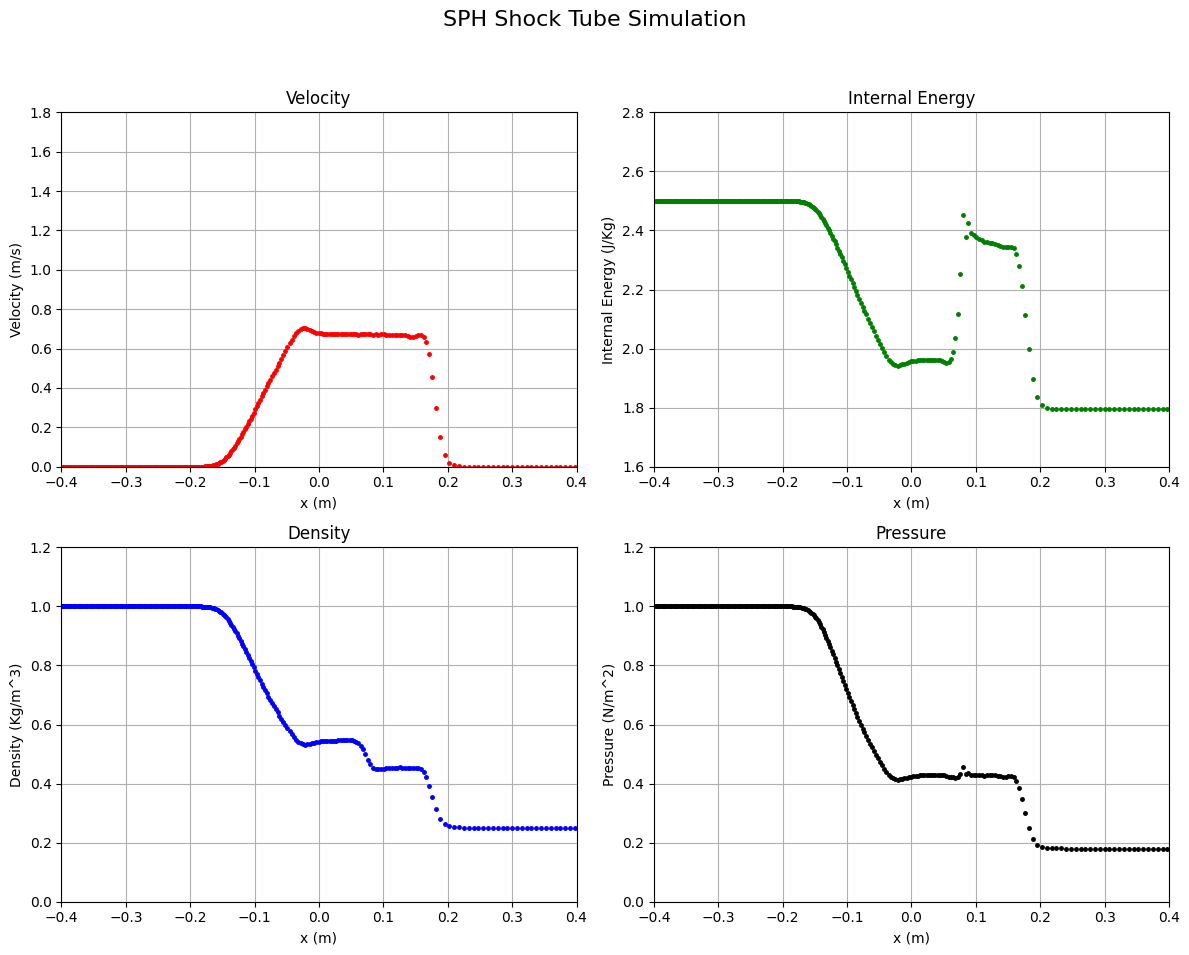

In [14]:
if __name__ == '__main__':
    simulation = ShockTubeSPH()
    simulation.run_simulation()
    simulation.create_animation()

Animation saved as 'shockwave.gif'. Now displaying in notebook...


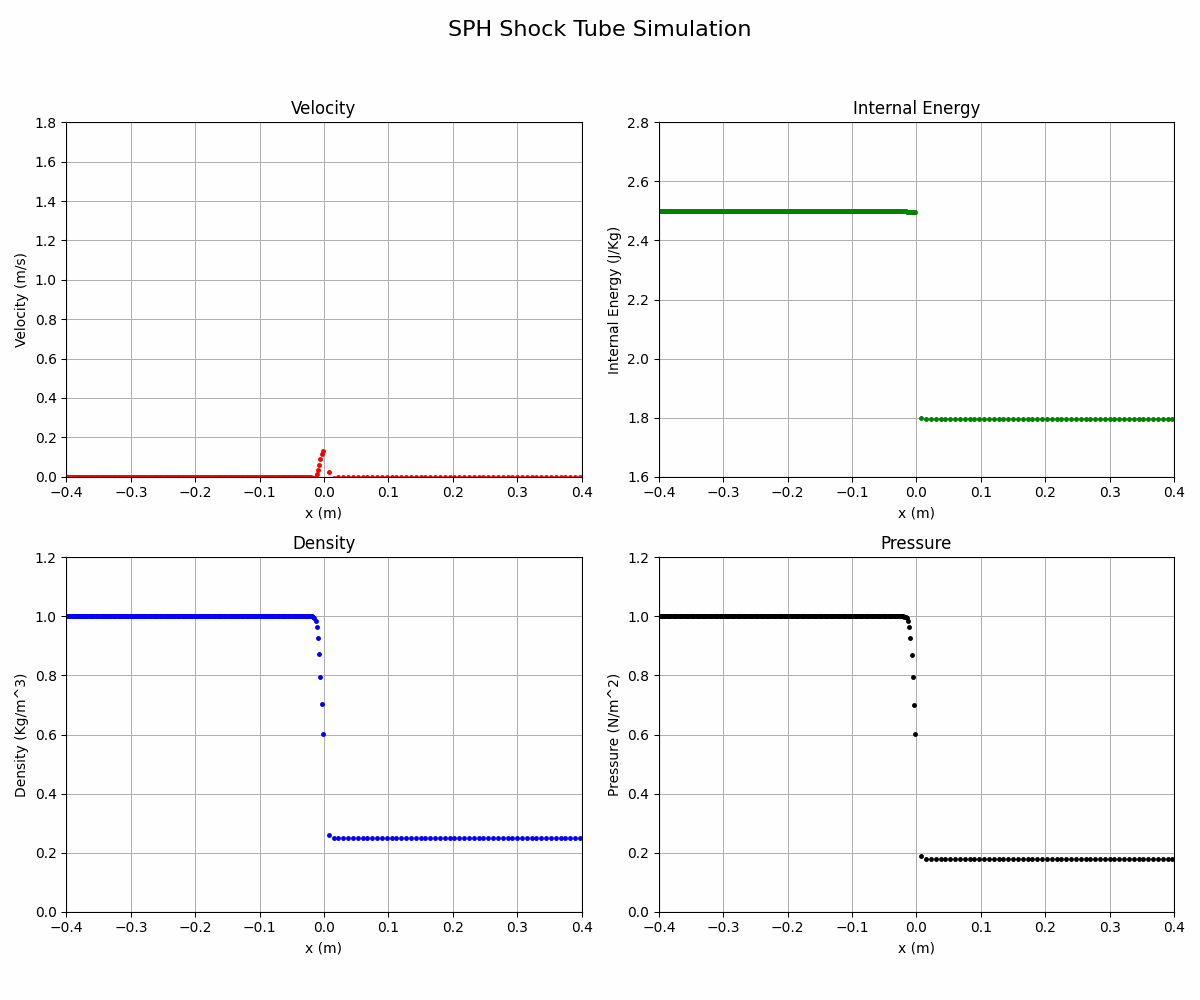

In [15]:
from IPython.display import display, Image

print(f"Animation saved as '{'shockwave.gif'}'. Now displaying in notebook...")
display(Image(filename='shockwave.gif'))